### 1. Loading EDF

In [1]:
import numpy as np
import mne 
from matplotlib import pyplot as plt
import pandas as pd

import os

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# path to one patient edf data

path = "/home/SharedFiles/Data/HospitalData/EEG/SNUCH_VEM_EDF"
file = os.path.join(path, 'SNUCH01.EDF')
label_sheet = os.path.join(path, 'SNUCH 2020 labeling 수정.xlsx')

In [3]:
df = pd.read_excel(label_sheet)

In [4]:
df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2
0,2022-05-03,17:26:46,Recording on
1,NaT,19:07:27,Start of seizure
2,NaT,19:07:54,End of seizure
3,2022-05-04,06:26:16,Start of seizure
4,NaT,06:26:45,End of seizure


In [5]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2'], dtype='object')

In [6]:
# read raw edf
# https://physionet.org/content/chbmit/1.0.0/

raw = mne.io.read_raw_edf(file)

Extracting EDF parameters from /home/SharedFiles/Data/HospitalData/EEG/SNUCH_VEM_EDF/SNUCH01.EDF...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [7]:
# get edf info
raw.info

<Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | Fp1-AVG, F3-AVG, C3-AVG, P3-AVG, Fp2-AVG, F4-AVG, ...
    chs : list | 27 items (EEG: 27)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 100.0 Hz
    meas_date : tuple | 2021-05-03 17:26:46 GMT
    nchan : int | 27
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 200.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    device_info : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    helium_info : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name 

In [8]:
channels = raw.ch_names
channels

['Fp1-AVG',
 'F3-AVG',
 'C3-AVG',
 'P3-AVG',
 'Fp2-AVG',
 'F4-AVG',
 'C4-AVG',
 'P4-AVG',
 'F7-AVG',
 'T1-AVG',
 'T3-AVG',
 'T5-AVG',
 'O1-AVG',
 'F8-AVG',
 'T2-AVG',
 'T4-AVG',
 'T6-AVG',
 'O2-AVG',
 'Fz-AVG',
 'Cz-AVG',
 'Pz-AVG',
 'EKG R-EKG L',
 'NECK-AVG',
 'LHE1-LHE2',
 'RHE1-RHE2',
 'LLE1-LLE2',
 'RLE1-RLE2']

In [9]:
len(channels)

27

In [23]:
raw

<RawEDF  |  SNUCH01.EDF, n_channels x n_times : 27 x 16789000 (83945.0 sec), ~55 kB, data not loaded>

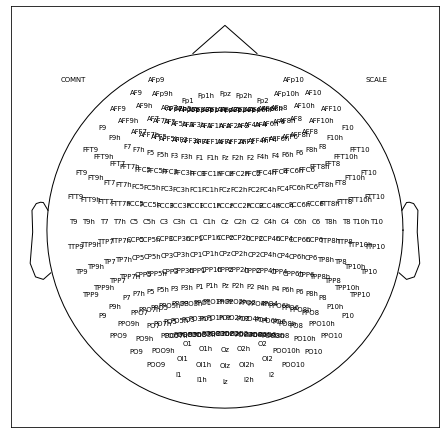

Effective window size : 5.120 (s)


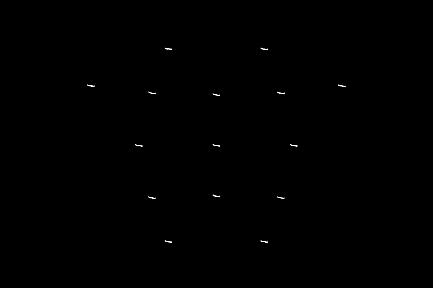

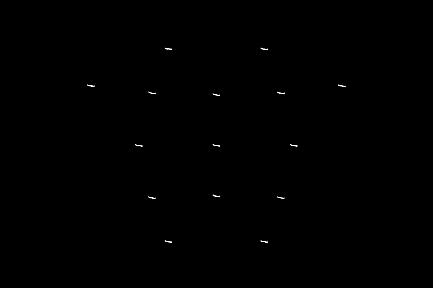

In [25]:
layout = mne.channels.read_layout('EEG1005')
layout.plot()
raw.plot_psd_topo(tmax=30., fmin=5., fmax=60., n_fft=1024, layout=layout)

In [26]:
# raw.plot_sensors(show_names=True)

In [27]:
# time indexing epoch (0-30 sec)
raw_epoch = raw.copy().crop(0, 30, include_tmax=False).load_data().notch_filter(freqs=60.0)

Reading 0 ... 5999  =      0.000 ...    29.995 secs...
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1321 samples (6.605 sec)



In [28]:
raw_epoch

<RawEDF  |  SNUCH01.EDF, n_channels x n_times : 27 x 6000 (30.0 sec), ~1.3 MB, data loaded>

In [29]:
len(raw_epoch)

6000

In [30]:
# extract data by ndarray
raw_selection = raw_epoch.get_data();raw_selection.shape

(27, 6000)

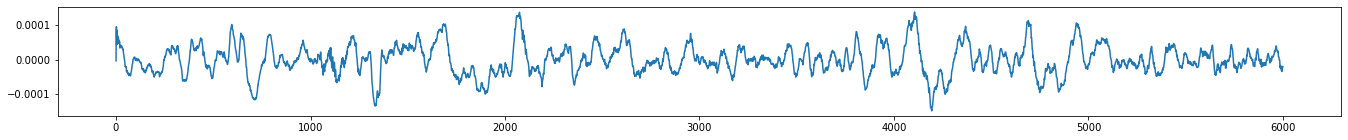

In [ ]:
# draw a plot of raw-signal by selected electrode
x = raw_selection[0]
plt.figure(figsize=(23, 2)) 
plt.plot(x)

### 2. Signal Processing

#### 1) Band-pass filtering

In [32]:
from scipy.signal import butter
from scipy.signal import filtfilt

In [33]:
# sampling frequency
fs = raw.info['sfreq']
# mininum pass frequency (fmax)
lowcut = 1
# maximum pass frequency (fmax)
highcut = 30
# order
order = 3

In [34]:
# band-pass filtering range from fmin to fmax
nyq = 0.5 * fs
low = lowcut / nyq
high = highcut / nyq
b, a = butter(order, [low, high], btype='band')
y = filtfilt(b, a, x)

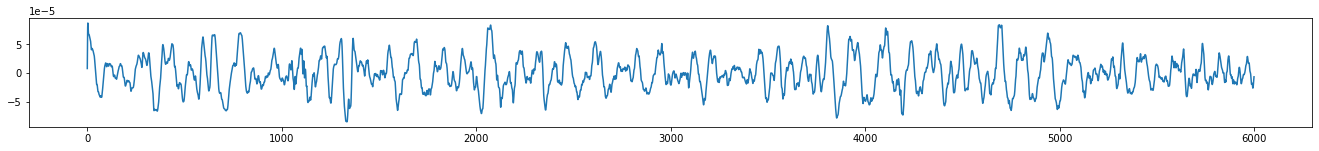

In [35]:
# draw a plot of band-pass filtered signal
plt.figure(figsize=(23, 2)) 
plt.plot(y)

#### 2) Short-time Fourier Transfrom(STFT)

In [36]:
from scipy.signal import stft 
from sklearn.preprocessing import MinMaxScaler

In [37]:
# Normalization (0-1)
# initialize scaler 
scaler = MinMaxScaler()

In [38]:
# STFT, window 1sec, overlap 50%
f, t, Zxx = stft(y, fs=fs, window='hanning', nperseg=fs, noverlap=(fs//2), boundary=None)
# absolute
Zxx = np.abs(Zxx)
# normalization
Zxx = scaler.fit_transform(10*np.log10(Zxx))

Text(0.5, 0, 'Time [sec]')

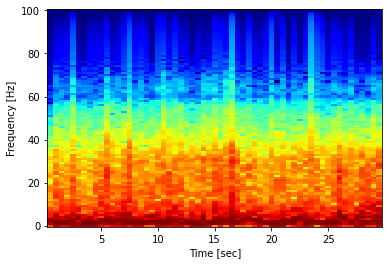

In [39]:
# draw a STFT plot
plt.pcolormesh(t, f, Zxx, cmap='jet')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

#### 3) Continuous Wavelet Transform(CWT)

In [40]:
from obspy.signal.tf_misfit import cwt

In [41]:
# declare parameters
dt = 1/fs
w0 = 2
nf = 100
fmin = lowcut
fmax = highcut

In [42]:
# CWT
scalogram = pow(np.abs(cwt(x, dt, w0, fmin, fmax, nf)), 2)

Text(0.5, 0, 'Time')

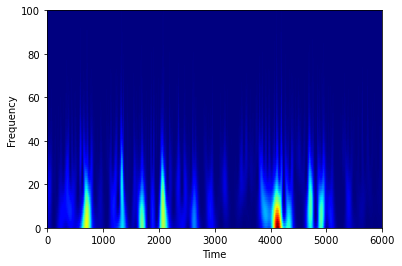

In [43]:
# draw a CWT plot
plt.pcolormesh(scalogram, cmap='jet')
plt.ylabel('Frequency')
plt.xlabel('Time')